In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
dir_path = '/content/drive/Othercomputers/macbook-air/TPS-Feb2022/notebooks'
os.chdir(dir_path)

In [3]:
! pip install japanize-matplotlib
! pip install shap
! pip install umap-learn

     |████████████████████████████████| 4.1 MB 4.7 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=05d7be3420131f7277e3bed2b1afec12388cf164299f7b59d01513a9eb0f5ff5
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
     |████████████████████████████████| 564 kB 4.7 MB/s 
     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 34.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=ccc74badfe3d23bc478b6de78f0e157d9810ce5a5a32bbf7f303ccfc3bb7ddd7
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=3b68d53f743339ea3114b418239d1900411344db806111f9548c08c570a3ba7b
  Stored in directory: 

In [4]:
import glob
import sys,os
import json
import pprint
import time
import re
import datetime
import pickle
import string
import gc
import warnings
import yaml
import os
warnings.filterwarnings("ignore")
sys.path.append(os.pardir)
sys.path.append('../..')
sys.path.append('../../..')

import numpy as np
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語対応
import seaborn as sns
# pandasのオプション
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 5000)
pd.options.display.float_format = '{:.3f}'.format
%matplotlib inline
# sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

from joblib import Parallel, delayed # よりお手軽にサクっと並列処理を実行出来るモジュール
from tqdm import tqdm, tqdm_notebook # プログレスバーを表示できる
from PIL import Image
tqdm.pandas()

# 外部モジュールを自動的にリロードする
%load_ext autoreload
%autoreload 2


# パスの定義
CONFIG_FILE = '../configs/config.yaml'

with open(CONFIG_FILE) as file:
    yml = yaml.load(file)
MODEL_DIR_NAME = yml['SETTING']['MODEL_DIR_NAME']
FEATURE_DIR_NAME = yml['SETTING']['FEATURE_DIR_NAME']
RAW_DIR_NAME = yml['SETTING']['RAW_DIR_NAME']
TARGET_ENCODING = yml['SETTING']['TARGET_ENCODING']

## 次元削減

In [27]:
! python ../code/reduce_dimension.py

[pca_output] start
[2022-02-26 05:44:16] - explained variance ratio: [0.24144714 0.39051441 0.43559955 0.46645542 0.48618584 0.50045494
 0.51230907 0.5235734  0.53408619 0.54402388 0.55321395 0.56203124
 0.57059624 0.57901564 0.58736188 0.59562483 0.60356096 0.6113477
 0.61900245 0.62644668 0.63379752 0.64065894 0.64695489 0.65314802
 0.65915388 0.66505739 0.67084619 0.67654816 0.68214442 0.68768747
 0.69313672 0.69849537 0.70380213 0.70896248 0.7140294  0.71887619
 0.72367743 0.72836649 0.73291781 0.73741368 0.74183534 0.74622368
 0.7505102  0.75467006 0.7588033  0.76291087 0.76690256 0.77086282
 0.77469462 0.77844243 0.78215167 0.78579087 0.78933671 0.7927757
 0.79610071 0.79940517 0.80267594 0.80584436 0.80896332 0.81197173
 0.81494411 0.81785711 0.82068531 0.82350145 0.82626916 0.82901588
 0.83173816 0.83441775 0.83707488 0.8396902  0.84229166 0.84487023
 0.84739392 0.84989249 0.8523668  0.85477861 0.85716509 0.8595193
 0.86181644 0.86408188 0.86632388 0.86854411 0.87075393 0.87289

## 予測結果の取得

In [5]:
REVERSE_TARGET_ENCODING = {v:k for k, v in TARGET_ENCODING.items()}

In [6]:
train = pd.read_csv(RAW_DIR_NAME + 'train.csv')
test =  pd.read_csv(RAW_DIR_NAME + 'test.csv')

# model_name = 'lgb_0211_0656'
# pred = pd.read_pickle(MODEL_DIR_NAME + model_name + f'/{model_name}-pred.pkl')
# pred[0] = pred[0].map(lambda x: REVERSE_TARGET_ENCODING[x])
# pred = pd.get_dummies(pred, prefix='', prefix_sep='')

In [ ]:
# 多クラス分類(実際の値と予測値の割合算出）
true_and_pred = pd.concat([train['target'], pred], axis=1)
true_and_pred = true_and_pred.iloc[:100000, :].groupby('target').sum()
true_and_pred = true_and_pred.apply(lambda x: x / x.sum(), axis=1)
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(true_and_pred, annot=True, ax=ax)

In [ ]:
plt.plot(train.iloc[0, 1:-1])

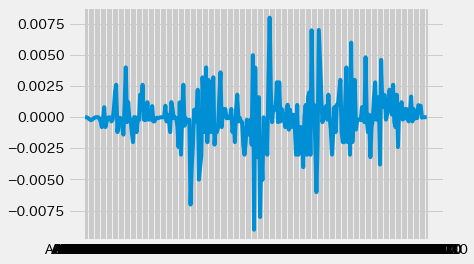

In [ ]:
plt.plot(train.iloc[100, 1:-1])

## クラスター

In [20]:
# （必要に応じて）データ分割
debug = True
if debug==True:
  from sklearn.model_selection import train_test_split
  test_size = 2000 / len(train)
  _, train_x, _, train_y = train_test_split(train.iloc[:, 1:-1], train['target'], test_size=test_size, stratify=train['target'])
else:
  train_x, train_y = train.iloc[:, 1:-1], train['target']

# ターゲットラベル
encorded_targets = train_y.map(lambda x: TARGET_ENCODING[x]).values
true_colors = [plt.get_cmap("tab10")(x) for x in encorded_targets]

# データの使用する列のみ抽出
dfs = train_x

### kmeans

In [ ]:
# kmeansでグループ分けして、各グループごとにcolorを割り振る
from sklearn.cluster import KMeans

k = 10
SEED = 42

kmeans_model = KMeans(n_clusters=k, random_state=SEED).fit(dfs.select_dtypes(exclude='object'))
labels = kmeans_model.labels_
kmeans_colors = [plt.get_cmap("tab10")(x) for x in labels]

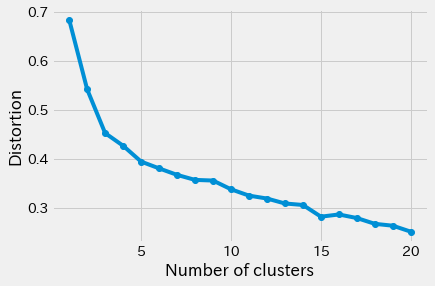

In [ ]:
# エルボー法（クラスター数の決め方1）
distortions = []
num = 20

for i  in range(1,num+1):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(dfs.select_dtypes(exclude='object'))
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,num+1),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

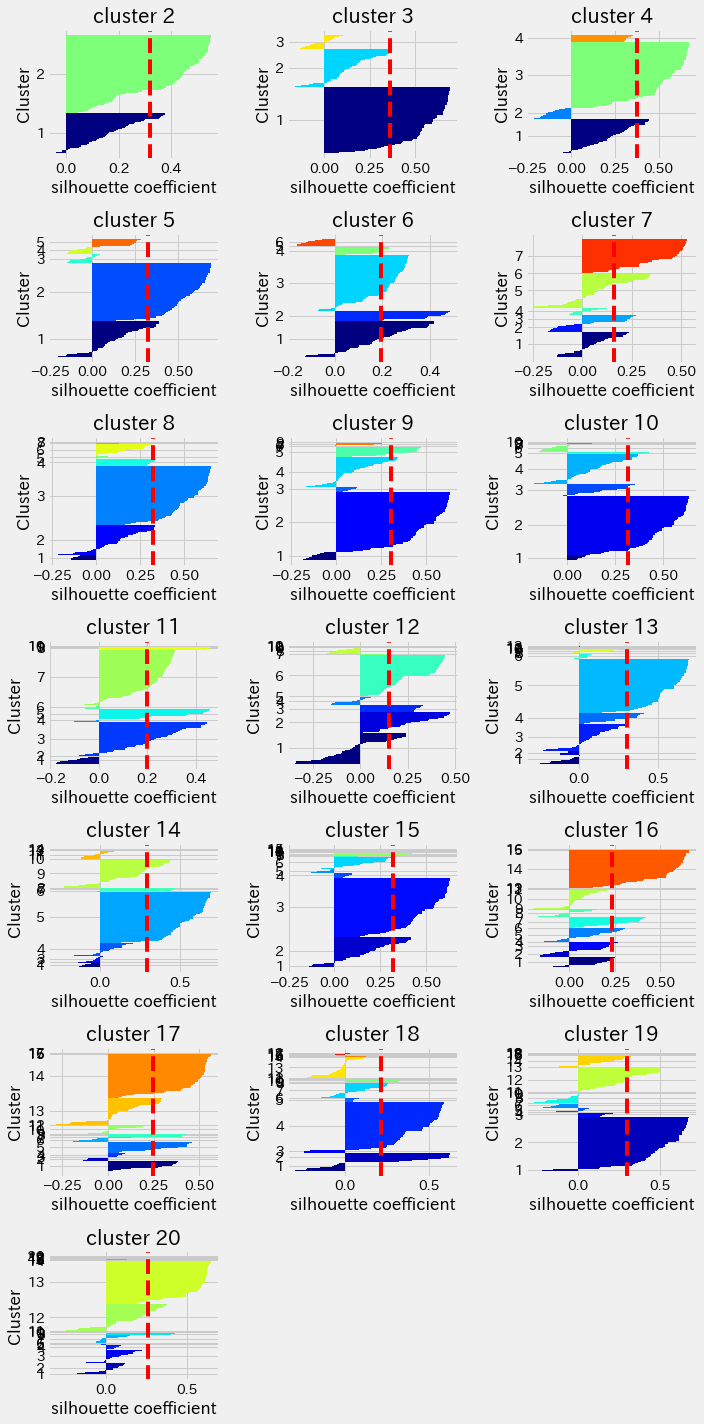

In [ ]:
# シルエット法（クラスター数の決め方1）
from sklearn.metrics import silhouette_samples
from matplotlib import cm

SEED = 42
num = 20
fig = plt.figure(figsize=(10,20))

for k in range(2, num+1):
    
    kmeans_num = KMeans(n_clusters=k, random_state=SEED).fit_predict(dfs.select_dtypes(exclude='object'))

    cluster_labels = np.unique(kmeans_num)       # y_kmの要素の中で重複を無くす
    n_clusters=cluster_labels.shape[0]     # 配列の長さを返す。つまりここでは n_clustersで指定した3となる

    # シルエット係数を計算
    silhouette_vals = silhouette_samples(dfs.select_dtypes(exclude='object'),
                                     kmeans_num,metric='euclidean')  # サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算
    y_ax_lower, y_ax_upper= 0,0
    yticks = []

    # グラフ
    plt.subplot((num//3+1), 3, k-1)
    
    for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[kmeans_num==c]      # cluster_labelsには 0,1,2が入っている（enumerateなのでiにも0,1,2が入ってる（たまたま））
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)              # サンプルの個数をクラスターごとに足し上げてy軸の最大値を決定
        color = cm.jet(float(i)/n_clusters)               # 色の値を作る
        plt.barh(range(y_ax_lower,y_ax_upper),            # 水平の棒グラフのを描画（底辺の範囲を指定）
                         c_silhouette_vals,               # 棒の幅（1サンプルを表す）
                         height=1.0,                      # 棒の高さ
                         edgecolor='none',                # 棒の端の色
                         color=color)                     # 棒の色
        yticks.append((y_ax_lower+y_ax_upper)/2)          # クラスタラベルの表示位置を追加
        y_ax_lower += len(c_silhouette_vals)              # 底辺の値に棒の幅を追加

    silhouette_avg = np.mean(silhouette_vals)                 # シルエット係数の平均値
    plt.axvline(silhouette_avg,color="red",linestyle="--")    # 係数の平均値に破線を引く
    plt.title(f"cluster {k}")
    plt.yticks(yticks,cluster_labels + 1)                     # クラスタレベルを表示
    plt.ylabel('Cluster')
    plt.xlabel('silhouette coefficient')

plt.tight_layout() # グラフ間の隙間を調整して座標部分が重なりを解消できる

### pca

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
data = train.iloc[:300, :]
feature = pca.fit_transform(data.drop(['row_id'], axis=1).select_dtypes(exclude='object'))

data_size = len(data)
target = 'target'
# data[target] = data[target].map(lambda x: TARGET_ENCODING[x]).values

# グラフ化
# fig, axes = plt.subplots(1, 2, figsize=(6, 6))
# sns.scatterplot(feature[:data_size, 0], feature[:data_size, 1], alpha=0.8, hue=target, data=data, ax=axes[0,0])

# fig, axes = plt.subplots(1, 1, figsize=(6, 6))
# sns.lineplot([n for n in range(1, len(pca.explained_variance_ratio_)+1)], np.cumsum(pca.explained_variance_ratio_), markers=True, ax=axes)
# plt.show()

### t-sne & umap

In [ ]:
# t-sne
from sklearn.manifold import TSNE

fig, ax = plt.subplots(figsize=(6,6))

i = 10

plt.title(f"perplexity: {i}")

model_tsne = TSNE(n_components=2, perplexity=i)
feature = model_tsne.fit_transform(dfs)

ax.scatter(feature[:, 0], feature[:, 1], alpha=0.8, color=true_colors)

NameError: ignored

## lda

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# all_data = pd.concat([train, test])

lda = LDA(n_components=2)
lda.fit(train_x, encorded_targets)

# lda.transform(b)
# test_x = lda.transform(test.iloc[:, 1:])

LinearDiscriminantAnalysis(n_components=2)

In [23]:
from keras.utils import np_utils

In [25]:
# lda.predict(train_x)
np_utils.to_categorical(encorded_targets)
lda.predict(encorded_targets)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
!pip install umap-learn

NameError: ignored

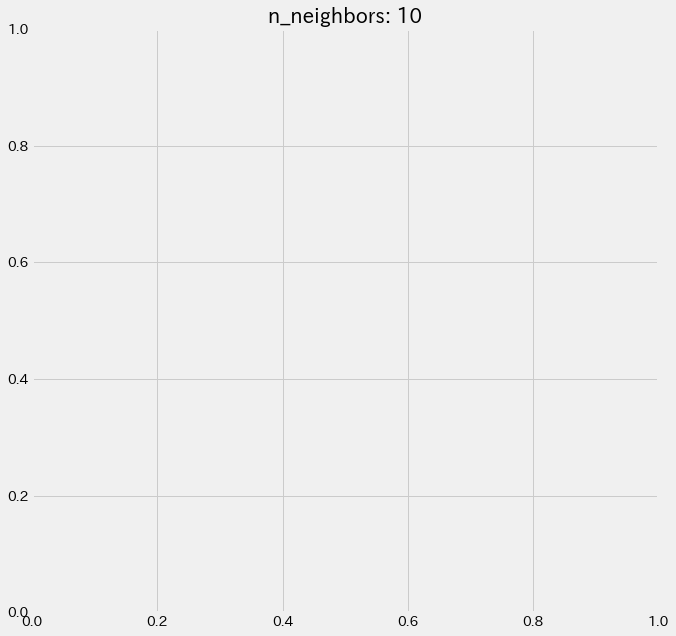

In [9]:
# umap
import umap.umap_ as umap
from scipy.sparse.csgraph import connected_components

fig, ax = plt.subplots(figsize=(10,10))

i = 10

ax.set_title(f"n_neighbors: {i}")

# model_umap = umap.UMAP(n_components=2, n_neighbors=i) 
# feature = model_umap.fit_transform(dfs.select_dtypes(exclude='object'))

sns.scatterplot(feature[:, 0], feature[:, 1], alpha=0.8, hue='target', data=pd.DataFrame(train_y), ax=ax)
# plt.show()


In [ ]:
# ! python ../code/generate_feature.py

## 次元削減